# Constant K

In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rc('font', **{'size': 15})
plt.rc('axes', labelsize=20)    # fontsize of the x and y labels
import scipy
from scipy import stats
from scipy.optimize import fsolve, root, curve_fit
import csv
import pandas as pd
from IPython.display import Image
import progressbar
import os
import uncertainties.unumpy as unp
import uncertainties as unc

In [2]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

def inch2m(inch):
    return inch * 0.0254

def m2inch(m):
    return m/0.0254

def loadcsvfile(filename, path='data/', delimiter=';'):
    exceldata = pd.read_excel(path+filename)
    exceldata.to_csv(path+'csv/'+filename[:-5]+'.csv', sep=delimiter, index=None, header=True)
    csvdata = pd.read_csv(path+'csv/'+filename[:-5]+'.csv', delimiter=delimiter)
    csvdata = csvdata.iloc[1:]
    csvdata.index -= 1
    for key in csvdata:
        if key != 'experiment':
            csvdata[key] = csvdata[key].astype('float')
    return csvdata

# Loading Noordland data and setting $h_0$ to $h_r$

In [3]:
# Noordland proeven (M1204)
NL1204 = loadcsvfile('Noordland_M1204.xlsx')
NL1204['h0'] = NL1204.hr
#Noordland referentieproeven
sel = np.arange(47)
NL1204ref = NL1204.iloc[sel]
#other proeven
NL1204other = NL1204.iloc[48:]

In [4]:
NL1204D3Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q4 = NL1204ref[(NL1204ref.Q==4e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q6 = NL1204ref[(NL1204ref.Q==6e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q7 = NL1204ref[(NL1204ref.Q==7e-3) & (NL1204ref.D==3.1e-2)]
NL1204D3Q8 = NL1204ref[(NL1204ref.Q==8e-3) & (NL1204ref.D==3.1e-2)]

NL1204D6Q1 = NL1204ref[(NL1204ref.Q==1e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q2 = NL1204ref[(NL1204ref.Q==2e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q3 = NL1204ref[(NL1204ref.Q==3e-3) & (NL1204ref.D==6.1e-2)]
NL1204D6Q5 = NL1204ref[(NL1204ref.Q==5e-3) & (NL1204ref.D==6.1e-2)]

reference_data = [NL1204D3Q1,NL1204D3Q3,NL1204D3Q5,NL1204D3Q7,
                  NL1204D6Q1,NL1204D6Q3,NL1204D6Q5]
refcol = np.array(['r', 'g', 'b', 'c', 'm', 'y', 'k'])

In [5]:
g = 9.81 # [m s^-2] gravitatieversnelling
rho_1 = 1000 # [kg m^-3] dichtheid zoet water
rho_2 = 1022 # [kg m^-3] dichtheid zout water
Drho = rho_2 - rho_1 # [kg m^-3] dichtheidsverschil
eps = Drho/rho_2
gp = eps*g

In [6]:
def transform(Gy, G, hL, P):
    return Gy + 2*G*(hL-P)

#simple linear fit function:
def f(x, slope, intercept):
    return slope*x + intercept

#linear fit function with fixed b
def func(x, a):
    return a - b*x

def linFit(x, y):
    """
    Linear fit through data.
    Returns:
    a: intercept
    b: slope
    r_value**2: R-squared
    p_value: P-value
    std_err: standard error
    """
    b, a, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return a, b, r_value**2, p_value, std_err

def fixedbFit(func, x, y):
    """
    Linear fit through data with a fixed value for the slope (b).
    Returns:
    a: intercept 
    r_squared: = R-squared
    """
    a = curve_fit(func, x, y)[0][0]
    residuals = y - func(x, *[a])
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return a, r_squared


def predband(x, xd, yd, p, func, conf=0.95):
    """
    x = requested points
    xd = x data
    yd = y data
    p = parameters
    func = function name
    conf = confidence level (default: 95%)
    """
    sig = 1.0 - conf    # significance
    N = xd.size          # data sample size
    var_n = len(p)  # number of parameters
    # Quantile of Student's t distribution for p=(1-alpha/2)
    q = stats.t.ppf(1.0 - sig / 2.0, N - var_n)
    # Stdev of an individual measurement
    se = np.sqrt(1. / (N - var_n) * \
                 np.sum((yd - func(xd, *p)) ** 2))
    # Auxiliary definitions
    sx = (x - xd.mean()) ** 2
    sxd = np.sum((xd - xd.mean()) ** 2)
    # Predicted values (best-fit model)
    yp = func(x, *p)
    # Prediction band
    dy = q * se * np.sqrt(1.0+ (1.0/N) + (sx/sxd))
    # Upper & lower prediction bands.
    lpb, upb = yp - dy, yp + dy
    return lpb, upb

In [28]:
coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                       'hL':np.zeros(len(reference_data)),
                       'a':np.zeros(len(reference_data)),
                       'b':np.zeros(len(reference_data))})

drsq = 0

K = 0.65
#create new directory for new K value:
Kdir = 'K='+str(K)
figpath = "figures/constant_K/using_hr/{}/".format(Kdir)
try:
    os.mkdir(figpath)
    print("New directory created: '{}'".format(figpath))
except:
    print("Directory '{}' already exists".format(figpath))
    
b = 1/(2*K)

print("Creating linear fits through Noordland reference data")
i = 0 #counter
for NL1204sel in reference_data: #NL1204sel is selected data set
    plt.clf()
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"$Gy$", ylabel=r'$c_0/c_2$', title=r"Noordland reference experiments {0}-{1}".format(NL1204sel.iloc[0].experiment, NL1204sel.iloc[-1].experiment))
    ax.axis([-2,1,0,1])
    ax.grid()
    #don't include data points where lam=0 in the fit
    lam0sel = np.where(NL1204sel.lam!=0)[0]
    P = NL1204sel.iloc[0].D/2
    G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
    y = NL1204sel.D/2 - NL1204sel.h0
    Gy = G*y
    c0c2 = 1 - NL1204sel.lam

    Gyfit = np.linspace(-4,3,1000)

    #fit keeping b fixed
    a, rsq = fixedbFit(func, Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    c0c2fit = a - b*Gyfit
    hL = 1/(2*np.mean(G)*b)

    #linear fit through datapoints
    al, bl, rsql, pl, stdl = linFit(Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
    bl = abs(bl)
    c0c2fitl = al - bl*Gyfit

    ax.plot(Gy, c0c2, 'o', color=refcol[i], label="Observed value")
    ax.plot(Gyfit, c0c2fit, 'k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(a,b,rsq))
    ax.plot(Gyfit, c0c2fitl, '-.k', label="${0:.2f}-{1:.2f}Gy$\n($R^2={2:.3f}$)".format(al,bl,rsql))
    
    drsq += rsql - rsq
    
    coeffa.P[i] = P
    coeffa.hL[i] = hL
    coeffa.a[i] = a
    coeffa.b[i] = b
    
    #"""
    if P<hL:
        Gyp = transform(Gy, G, hL, P)
        ap = curve_fit(func, Gyp.iloc[lam0sel], c0c2.iloc[lam0sel])[0][0]
        c0c2fitp = ap - b*Gyfit
        coeffa.a[i] = ap
        coeffa.b[i] = b

        ax.plot(Gyp, c0c2, 'X', color=refcol[i], label="Adjusted value")
        ax.plot(Gyfit, c0c2fitp, '--k', label="${0:.2f}-{1:.2f}Gy'$".format(ap,b))
    #"""

    ax.legend()
    ax.invert_xaxis()
    plt.savefig(figpath+"{0}-{1}.pdf".format(NL1204sel.iloc[0].experiment, NL1204sel.iloc[-1].experiment))
    plt.close()
    i += 1

Directory 'figures/constant_K/using_hr/K=0.65/' already exists
Creating linear fits through Noordland reference data


<Figure size 432x288 with 0 Axes>

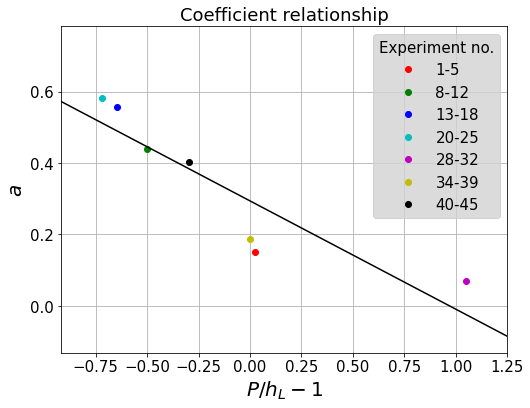

In [29]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$P/h_L-1$", ylabel=r'$a$', title=r"Coefficient relationship".format(K))
ax.axis([min(coeffa.P/coeffa.hL-1)-0.2,max(coeffa.P/coeffa.hL-1)+0.2,
         min(coeffa.a)-0.2, max(coeffa.a)+0.2])
ax.grid()

xfit = np.linspace(-20,20,1000)
intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
afit = slope*xfit+intercept

[ax.plot(coeffa.P[i]/coeffa.hL[i]-1, coeffa.a[i], 'o', color=refcol[i], label=reference_data[i].experiment.iloc[0]+'-'+reference_data[i].experiment.iloc[-1]) for i in range(len(reference_data))]
ax.plot(xfit,afit,'k')

plt.legend(title=r"Experiment no.", loc='upper right', facecolor="lightgray")
plt.savefig(figpath+"Coefficient relationship.pdf")

In [9]:
r_squared

0.8071678577717645

# Computed versus observed

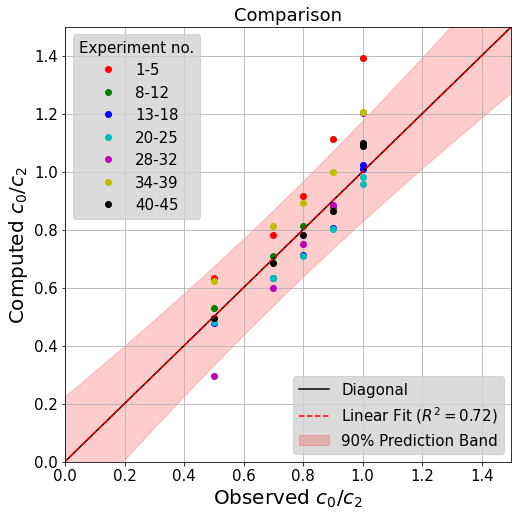

In [30]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison".format(K))
ax.axis([0,1.5,0,1.5])
ax.grid()

c0c2comp_all = np.array([])
c0c2obs_all = np.array([])

i = 0
for NL1204sel in reference_data:
    #NL1204sel = NL1204ref

    c0c2obs = 1 - NL1204sel.lam
    G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
    P = NL1204sel.D/2
    y = P - NL1204sel.h0

    hL = K/G
    acomp = np.interp(P/hL-1,xfit,afit)
    c0c2comp = acomp - b*G*y
    # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
    c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
    # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
    #c0c2comp[c0c2comp<0] = 0
    #c0c2comp[c0c2comp>1] = 1
    
    c0c2obs_all = np.append(c0c2obs_all, c0c2obs[c0c2obs<1])
    c0c2comp_all = np.append(c0c2comp_all, c0c2comp[c0c2obs<1])
    
    ax.plot(c0c2obs, c0c2comp, 'o', color=refcol[i], label=reference_data[i].experiment.iloc[0]+'-'+reference_data[i].experiment.iloc[-1])
    i+=1

lgd1 = plt.legend(title="Experiment no.", loc='upper left', facecolor='lightgray')

diagplot = ax.axline([1,1],slope=1, color='k', label='Diagonal')

# fit a curve to the data using a least squares 1st order polynomial fit
# from https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
n = len(c0c2comp_all)
popt, pcov = curve_fit(f, c0c2obs_all, c0c2comp_all)
slope = popt[0]
intercept = popt[1]
r2 = 1.0-(sum((c0c2comp_all-f(c0c2obs_all,slope,intercept))**2)/((n-1.0)*np.var(c0c2comp_all,ddof=1)))
slope, intercept = unc.correlated_values(popt, pcov)

# calculate regression confidence interval
px = np.linspace(-2, 2, 100)
py = slope*px + intercept
nom = unp.nominal_values(py)
std = unp.std_devs(py)

lpb, upb = predband(px, c0c2obs_all, c0c2comp_all, popt, f, conf=0.9)

# plot the regression
regplot, = ax.plot(px, nom, '--r', label="Linear Fit ($R^2={0:.2f}$)".format(r2))

# uncertainty lines (90% confidence)
#ax.plot(px, nom - 1.96 * std, c='orange',label='90% Confidence Region')
#ax.plot(px, nom + 1.96 * std, c='orange')

#ax.plot(px, lpb, 'grey', linestyle='--', label='90% Prediction Band')
#ax.plot(px, upb, 'grey', linestyle='--')
predplot = ax.fill_between(px, lpb, upb, alpha=0.2, color='red', label="90% Prediction Band")

lgd2 = plt.legend([diagplot,regplot,predplot], [diagplot.get_label(),regplot.get_label(),predplot.get_label()],
                 facecolor='lightgrey', loc='lower right')
ax.add_artist(lgd1)

plt.savefig(figpath+"comparison_plot.pdf")

In [11]:
def reference_comparison():
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison")
    ax.axis([0,1.5,0,1.5])
    ax.grid()

    NL1204sel = NL1204ref.iloc[np.where(~np.isnan(NL1204ref.am))]
    c0c2obs = 1 - NL1204sel.lam
    G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
    P = NL1204sel.D/2
    y = P - NL1204sel.h0

    hL = K/G
    acomp = np.interp(P/hL-1,xfit,afit)
    c0c2comp = acomp - b*G*y
    # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
    c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))

    refpoints, = ax.plot(c0c2obs, c0c2comp, '+k', label="Reference data")

    diagplot = ax.axline([1,1],slope=1, color='k', label='Diagonal')

    # fit a curve to the data using a least squares 1st order polynomial fit
    # from https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
    x = c0c2obs[c0c2obs<1]
    y = c0c2comp[c0c2obs<1]
    n = len(y)
    popt, pcov = curve_fit(f, x, y)
    slope = popt[0]
    intercept = popt[1]
    r2 = 1.0-(sum((y-f(x,slope,intercept))**2)/((n-1.0)*np.var(y,ddof=1)))
    slope, intercept = unc.correlated_values(popt, pcov)

    # calculate regression confidence interval
    px = np.linspace(-2, 2, 100)
    py = slope*px + intercept
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)

    lpb, upb = predband(px, x, y, popt, f, conf=0.9)

    # plot the regression
    regplot, = ax.plot(px, nom, '--r', label="Linear Fit ($R^2={0:.2f}$)".format(r2))

    # uncertainty lines (90% confidence)
    #ax.plot(px, nom - 1.96 * std, c='orange',label='90% Confidence Region')
    #ax.plot(px, nom + 1.96 * std, c='orange')

    #ax.plot(px, lpb, 'grey', linestyle='--', label='90% Prediction Band')
    #ax.plot(px, upb, 'grey', linestyle='--')
    predplot = ax.fill_between(px, lpb, upb, alpha=0.2, color='red', label="90% Prediction Band")

    lgd = plt.legend([refpoints, diagplot,regplot,predplot], [refpoints.get_label(), diagplot.get_label(),regplot.get_label(),predplot.get_label()],
                     facecolor='lightgrey', loc='lower right')
    return fig, ax, lgd

# All Noordland data

In [22]:
def plot_comparison(datasets, colors, title):
    fig, ax, lgd = reference_comparison()
    ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison "+title)
    
    lines = []
    i = 0
    for NL1204sel in datasets:
        c0c2obs = 1 - NL1204sel.lam
        G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
        P = NL1204sel.D/2
        y = P - NL1204sel.h0

        hL = K/G
        acomp = np.interp(P/hL-1,xfit,afit)
        c0c2comp = acomp - b*G*y
        # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
        c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
        # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
        #c0c2comp[c0c2comp<0] = 0
        #c0c2comp[c0c2comp>1] = 1

        lines += ax.plot(c0c2obs, c0c2comp, 'o', color=colors[i], label=NL1204sel.experiment.iloc[0]+'-'+NL1204sel.experiment.iloc[-1])
        #dataplots = np.append(dataplots, dataplot)
        i+=1
    
    labels = [l.get_label() for l in lines]
    
    plt.legend(lines, labels, loc='upper left', title='Experiment no.', facecolor='lightgrey')
    ax.add_artist(lgd)
    #plt.show()
    plt.savefig(figpath+"comparison_plot_{}.pdf".format(title.replace(' ','_')), bbox_inches='tight')

In [23]:
# zonder afzuigconstructie
sel = np.arange(47,56)
NL1204noex = NL1204.iloc[sel]
NL1204noexD3 = NL1204noex[NL1204noex.D==3.1e-2]
NL1204noexD6 = NL1204noex[NL1204noex.D==6.1e-2]
noEx = pd.DataFrame({
    'datasets': [NL1204noexD3, NL1204noexD6],
    'colors': ['b','r'],
    'title': "experiments without extraction construction",
    'notes': ''
})

#delta rho ~ 2
sel = np.arange(77,99)
NL1204eps2 = NL1204.iloc[sel]
NL1204eps2D3 = NL1204eps2[NL1204eps2.D==3.1e-2]
NL1204eps2D6 = NL1204eps2[NL1204eps2.D==6.1e-2]

deltarho2 = [NL1204eps2D3, NL1204eps2D6[NL1204eps2D6.Q_1000==1], 
             NL1204eps2D6[NL1204eps2D6.Q_1000==3], NL1204eps2D6[NL1204eps2D6.Q_1000==5]]
deltarho2_col = ['g','y','m','c']

ref2 = pd.DataFrame({
    'datasets': [NL1204eps2D3, NL1204eps2D6[NL1204eps2D6.Q_1000==1], 
                NL1204eps2D6[NL1204eps2D6.Q_1000==3], NL1204eps2D6[NL1204eps2D6.Q_1000==5]],
    'colors': ['g','y','m','c'],
    'title': r"reference experiments ($\Delta\rho \propto 2$)",
    'notes': ''
})

# gravel bed
sel = np.arange(99,111)
NL1204gravel = NL1204.iloc[sel]
NL1204gravelQ1 = NL1204gravel[NL1204gravel.Q_1000==1]
NL1204gravelQ3 = NL1204gravel[NL1204gravel.Q_1000==3]
NL1204gravelQ5 = NL1204gravel[NL1204gravel.Q_1000==5]
gravelbed = pd.DataFrame({
    'datasets': [NL1204gravelQ1, NL1204gravelQ3, NL1204gravelQ5],
    'colors': ['r','g','b'],
    'title': "experiments with gravel bed",
    'notes': ''
})

# rounded screen
sel = np.arange(111,125)
NL1204round = NL1204.iloc[sel]
NL1204roundQ1 = NL1204round[NL1204round.Q_1000==1]
NL1204roundQ3 = NL1204round[NL1204round.Q_1000==3]
NL1204roundQ5 = NL1204round[NL1204round.Q_1000==5]
roundedscreen = pd.DataFrame({
    'datasets': [NL1204roundQ1, NL1204roundQ3, NL1204roundQ5],
    'colors': ['r','g','b'],
    'title': "experiments with rounded screen",
    'notes': ''
})

# pillars
sel = np.arange(125,138)
NL1204pillars = NL1204.iloc[sel]
NL1204pillarsQ1 = NL1204pillars[NL1204pillars.Q_1000==1]
NL1204pillarsQ3 = NL1204pillars[NL1204pillars.Q_1000==3]
NL1204pillarsQ5 = NL1204pillars[NL1204pillars.Q_1000==5]
pillars = pd.DataFrame({
    'datasets': [NL1204pillarsQ1, NL1204pillarsQ3, NL1204pillarsQ5],
    'colors': ['r','g','b'],
    'title': "experiments with pillars",
    'notes': ''
})

# sharp interface and mixing layer
sel = np.arange(138,148)
NL1204enduranceSharp = NL1204.iloc[sel]
sel = np.arange(148,158)
NL1204enduranceMix = NL1204.iloc[sel]
endurance = pd.DataFrame({
    'datasets': [NL1204enduranceSharp, NL1204enduranceMix],
    'colors': ['r', 'b'],
    'title': "endurance experiments",
    'notes': ["with sharp interface", "with mixing layer"]
})

# no remarks
sel = range(56,77)
NL1204none1 = NL1204.iloc[sel]
sel = np.arange(158,171)
NL1204none2 = NL1204.iloc[sel]
sel = np.arange(171,179)
NL1204none3 = NL1204.iloc[sel]
none = pd.DataFrame({
    'datasets': [NL1204none1, NL1204none2, NL1204none3],
    'colors': ['r', 'b', 'g'],
    'title': "experiments with no remarks",
    'notes': ''
})

In [24]:
plot_comparison(noEx.datasets, noEx.colors, title=noEx.title[0]); plt.close()
plot_comparison(ref2.datasets, ref2.colors, title=ref2.title[0]); plt.close()
plot_comparison(gravelbed.datasets, gravelbed.colors, title=gravelbed.title[0]); plt.close()
plot_comparison(roundedscreen.datasets, roundedscreen.colors, title=roundedscreen.title[0]); plt.close()
plot_comparison(pillars.datasets, pillars.colors, title=pillars.title[0]); plt.close()
plot_comparison(endurance.datasets, endurance.colors, title=endurance.title[0]); plt.close()
plot_comparison(none.datasets, none.colors, title=none.title[0]); plt.close()

# Different discharge Q

In [25]:
def plot_comparison_discharges(datasets, colors, title):
    fig, ax, lgd = reference_comparison()
    ax.set(xlabel=r"Observed $c_0/c_2$", ylabel=r'Computed $c_0/c_2$', title=r"Comparison "+title)
    
    lines = []
    i = 0
    for NL1204sel in datasets:
        c0c2obs = 1 - NL1204sel.lam
        G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
        P = NL1204sel.D/2
        y = P - NL1204sel.h0

        hL = K/G
        acomp = np.interp(P/hL-1,xfit,afit)
        c0c2comp = acomp - b*G*y
        # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
        c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
        # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
        #c0c2comp[c0c2comp<0] = 0
        #c0c2comp[c0c2comp>1] = 1

        lines += ax.plot(c0c2obs, c0c2comp, 'o', color=colors[i], label=NL1204sel.experiment.iloc[0]+'-'+NL1204sel.experiment.iloc[-1])
        #dataplots = np.append(dataplots, dataplot)
        i+=1
    
    labels = [l.get_label() for l in lines]
    
    #plt.legend(lines, labels, loc='upper left', title='Experiment no.', facecolor='lightgrey')
    #ax.add_artist(lgd)
    #plt.show()
    plt.savefig(figpath+"comparison_plot_{}.pdf".format(title.replace(' ','_').replace('/','p')), bbox_inches='tight')

In [26]:
# Different discharges
#Q=1L/s
sel = np.where((NL1204other.Q_1000==1)&(NL1204other.lam!=0))[0]
NL1204Q1 = NL1204other.iloc[sel]
discharge1 = pd.DataFrame({
    'datasets': [NL1204Q1],
    'colors': ['b'],
    'title': r"experiments with $Q=1$ L/s",
    'notes': ''
})

#Q=3L/s
sel = np.where((NL1204other.Q_1000==3)&(NL1204other.lam!=0))[0]
NL1204Q3 = NL1204other.iloc[sel]
discharge3 = pd.DataFrame({
    'datasets': [NL1204Q3],
    'colors': ['b'],
    'title': r"experiments with $Q=3$ L/s",
    'notes': ''
})

#Q=5L/s
sel = np.where((NL1204other.Q_1000==5)&(NL1204other.lam!=0))[0]
NL1204Q5 = NL1204other.iloc[sel]
discharge5 = pd.DataFrame({
    'datasets': [NL1204Q5],
    'colors': ['b'],
    'title': r"experiments with $Q=5$ L/s",
    'notes': ''
})

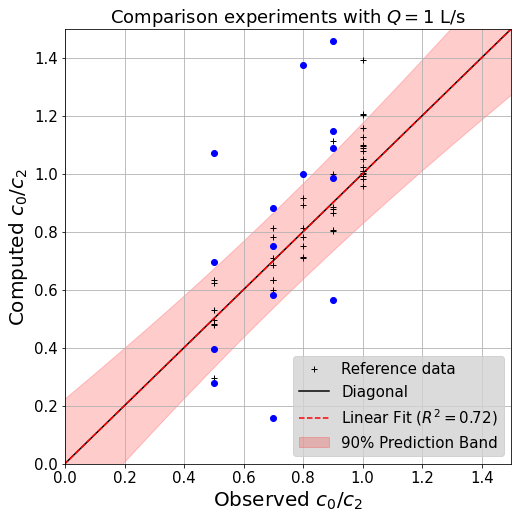

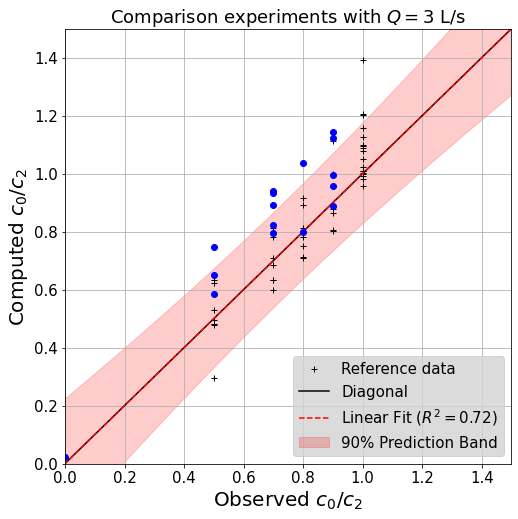

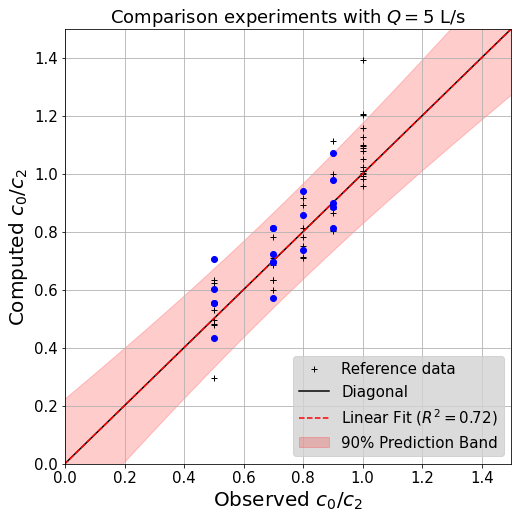

In [27]:
plot_comparison_discharges(discharge1.datasets, discharge1.colors, title=discharge1.title[0])
plot_comparison_discharges(discharge3.datasets, discharge3.colors, title=discharge3.title[0])
plot_comparison_discharges(discharge5.datasets, discharge5.colors, title=discharge5.title[0])

# Looping over different values of K to choose best

In [23]:
K_arr = np.linspace(0.1,1,500)

fitstats = pd.DataFrame({
    'K': K_arr,
    'rsq': np.zeros(len(K_arr)),
    'p_value': np.zeros(len(K_arr)),
    'std_err': np.zeros(len(K_arr)),
    'drsq': np.zeros(len(K_arr)),
    'maxdrsq': np.zeros(len(K_arr))
})

coeffa = pd.DataFrame({
    'P':np.zeros(len(reference_data)),
    'hL':np.zeros(len(reference_data)),
    'a':np.zeros(len(reference_data)),
    'b':np.zeros(len(reference_data))
})

for jj in progressbar.progressbar(range(len(K_arr))):
    K = K_arr[jj]  
    b = 1/(2*K)
    drsq = 0
    maxdrsq = 0
    
    i = 0 #counter
    for dataset in reference_data:
        #select which dataset, leaving out the datapoints where lam=0
        sel = np.where(dataset.lam!=0)[0]
        NL1204sel = dataset
        P = NL1204sel.iloc[0].D/2
        G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
        y = NL1204sel.D/2 - NL1204sel.h0
        Gy = G*y
        c0c2 = 1 - NL1204sel.lam

        Gyfit = np.linspace(-4,3,1000)

        #fit keeping b fixed
        a, rsq = fixedbFit(func, Gy.iloc[sel], c0c2.iloc[sel])
        c0c2fit = a - b*Gyfit
        hL = 1/(2*np.mean(G)*b)

        #linear fit through datapoints
        al, bl, rsql, pl, stdl = linFit(Gy.iloc[sel], c0c2.iloc[sel])
        bl = abs(bl)
        c0c2fitl = al - bl*Gyfit

        drsq += rsql - rsq
        if rsql - rsq > maxdrsq:
            maxdrsq = drsq
        
        coeffa.P[i] = P
        coeffa.hL[i] = hL
        coeffa.a[i] = a
        coeffa.b[i] = b

        #"""
        if P<hL:
            Gyp = transform(Gy, G, hL, P)
            ap = curve_fit(func, Gyp.iloc[sel], c0c2.iloc[sel])[0][0]
            c0c2fitp = ap - b*Gyfit
            coeffa.a[i] = ap
            coeffa.b[i] = b
        #"""

        i += 1

    xfit = np.linspace(-20,20,1000)
    intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
    afit = slope*xfit+intercept
    fitstats.rsq[jj], fitstats.p_value[jj], fitstats.std_err[jj], fitstats.drsq[jj], fitstats.maxdrsq[jj] = r_squared, p_value, std_err, drsq/i, maxdrsq

100% (500 of 500) |######################| Elapsed Time: 0:02:01 Time:  0:02:01


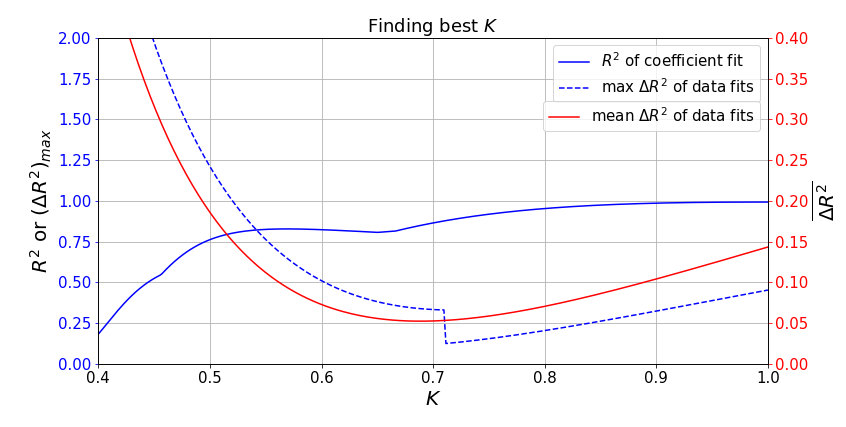

In [24]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111)
ax.set(xlabel=r"$K$", ylabel=r'$R^2$ or $(\Delta R^2)_{max}$', title=r"Finding best $K$")
ax.axis([0,1,0,2])
ax.grid()
ax.set_position([0.1,0.1,0.5,0.8])
bx = ax.twinx()
bx.axis([0.4,1,0,0.4])

ax.plot(fitstats.K, fitstats.rsq, 'b', label='$R^2$ of coefficient fit')
ax.plot(fitstats.K, fitstats.maxdrsq, '--b', label='max $\Delta R^2$ of data fits')
ax.tick_params(axis='y', colors='b')
ax.legend(loc='upper right')
#bx.plot(fitstats.K, fitstats.p_value, 'r')
#bx.plot(fitstats.K, fitstats.std_err, 'g')
bx.plot(fitstats.K, fitstats.drsq, 'r', label='mean $\Delta R^2$ of data fits')
bx.tick_params(axis='y', colors='r')
bx.set_ylabel(r"$\overline{\Delta R^2}$")
bx.legend(loc='upper right', bbox_to_anchor=(1,0.83))

In [21]:
first = fitstats[fitstats.K<0.6]
second = fitstats[fitstats.K>=0.6]
print('best rsq first part:')
print(first[first.rsq==max(first.rsq)])
print('------------------------------------------')
print('best rsq second part:')
print(second[second.rsq==max(second.rsq)])
print('------------------------------------------')
print('best drsq:')
print(fitstats[fitstats.drsq==min(fitstats.drsq)])
print('------------------------------------------')
print('best maxdrsq first part:')
print(fitstats[fitstats.maxdrsq==min(first.maxdrsq)])
print('------------------------------------------')
print('best maxdrsq second part:')
print(fitstats[fitstats.maxdrsq==min(second.maxdrsq)])
print('------------------------------------------')

best rsq first part:
            K       rsq   p_value   std_err      drsq   maxdrsq
260  0.568938  0.828277  0.004432  0.044029  0.093973  0.649015
------------------------------------------
best rsq second part:
            K       rsq   p_value   std_err     drsq   maxdrsq
495  0.992786  0.993058  0.000001  0.022158  0.14059  0.444143
------------------------------------------
best drsq:
            K       rsq   p_value   std_err      drsq   maxdrsq
326  0.687976  0.848738  0.003201  0.063629  0.052529  0.339753
------------------------------------------
best maxdrsq first part:
            K       rsq   p_value   std_err      drsq   maxdrsq
277  0.599599  0.823722  0.004741  0.051535  0.073164  0.511846
------------------------------------------
best maxdrsq second part:
            K       rsq   p_value   std_err      drsq   maxdrsq
339  0.711423  0.879274  0.001799  0.059107  0.053498  0.125623
------------------------------------------


# Best comparison fit

In [14]:
K_arr = np.linspace(0.3,0.8,200)
r2_arr = np.zeros(len(K_arr))
theta_arr = np.zeros(len(K_arr))

for kk in progressbar.progressbar(range(len(K_arr))):
    K = K_arr[kk]
    #empty dataframe to fill in coefficient a and other values
    coeffa = pd.DataFrame({'P':np.zeros(len(reference_data)),
                           'hL':np.zeros(len(reference_data)),
                           'a':np.zeros(len(reference_data)),
                           'b':np.zeros(len(reference_data))})

    drsq = 0
    b = 1/(2*K)

    i = 0 #counter
    for NL1204sel in reference_data: #NL1204sel is selected data set
        #don't include data points where lam=0 in the fit
        lam0sel = np.where(NL1204sel.lam!=0)[0]
        P = NL1204sel.iloc[0].D/2
        G = pow(NL1204sel.rhofrac*9.81,1/3)/pow(NL1204sel.q,2/3)
        y = NL1204sel.D/2 - NL1204sel.h0
        Gy = G*y
        c0c2 = 1 - NL1204sel.lam

        Gyfit = np.linspace(-4,3,1000)

        #fit keeping b fixed
        a, rsq = fixedbFit(func, Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
        c0c2fit = a - b*Gyfit
        hL = 1/(2*np.mean(G)*b)

        #linear fit through datapoints
        al, bl, rsql, pl, stdl = linFit(Gy.iloc[lam0sel], c0c2.iloc[lam0sel])
        bl = abs(bl)
        c0c2fitl = al - bl*Gyfit

        drsq += rsql - rsq

        coeffa.P[i] = P
        coeffa.hL[i] = hL
        coeffa.a[i] = a
        coeffa.b[i] = b

        #"""
        if P<hL:
            Gyp = transform(Gy, G, hL, P)
            ap = curve_fit(func, Gyp.iloc[lam0sel], c0c2.iloc[lam0sel])[0][0]
            c0c2fitp = ap - b*Gyfit
            coeffa.a[i] = ap
            coeffa.b[i] = b

        i += 1

    xfit = np.linspace(-20,20,1000)
    intercept, slope, r_squared, p_value, std_err = linFit(coeffa.P/coeffa.hL-1, coeffa.a)
    afit = slope*xfit+intercept

    c0c2comp_all = np.array([])
    c0c2obs_all = np.array([])

    i = 0
    for NL1204sel in reference_data:
        #NL1204sel = NL1204ref

        c0c2obs = 1 - NL1204sel.lam
        G = pow(NL1204sel.rhofrac*9.81/NL1204sel.q**2,1/3)
        P = NL1204sel.D/2
        y = P - NL1204sel.h0

        hL = K/G
        acomp = np.interp(P/hL-1,xfit,afit)
        c0c2comp = acomp - b*G*y
        # if P<hL, the value of a from the graph is for y', so transformation back to y is needed:
        c0c2comp[P<=hL] = acomp[P<=hL] - b*G[P<=hL]*(y[P<=hL] + 2*(hL[P<=hL]-P[P<=hL]))
        # forcing c0/c2 to 0 or 1 when the computed value is <0 or >1, respectively:
        #c0c2comp[c0c2comp<0] = 0
        #c0c2comp[c0c2comp>1] = 1

        c0c2obs_all = np.append(c0c2obs_all, c0c2obs[c0c2obs<1])
        c0c2comp_all = np.append(c0c2comp_all, c0c2comp[c0c2obs<1])

        i+=1

    # fit a curve to the data using a least squares 1st order polynomial fit
    # from https://apmonitor.com/che263/index.php/Main/PythonRegressionStatistics
    n = len(c0c2comp_all)
    popt, pcov = curve_fit(f, c0c2obs_all, c0c2comp_all)
    slope = popt[0]
    intercept = popt[1]
    r2 = 1.0-(sum((c0c2comp_all-f(c0c2obs_all,slope,intercept))**2)/((n-1.0)*np.var(c0c2comp_all,ddof=1)))
    r2_arr[kk] = r2
    theta = abs(np.arctan((slope-1)/(1+1*slope))/np.pi*180) #angle between fit and diagonal (in deg)
    theta_arr[kk] = theta
    slope, intercept = unc.correlated_values(popt, pcov)

    # calculate regression confidence interval
    px = np.linspace(-2, 2, 100)
    py = slope*px + intercept
    nom = unp.nominal_values(py)
    std = unp.std_devs(py)

    lpb, upb = predband(px, c0c2obs_all, c0c2comp_all, popt, f, conf=0.9)

100% (200 of 200) |######################| Elapsed Time: 0:00:39 Time:  0:00:39


array([0.64924623])

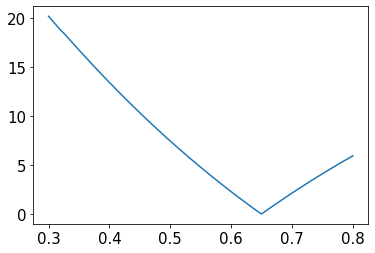

In [15]:
plt.plot(K_arr, theta_arr)
K_arr[theta_arr==np.nanmin(theta_arr)]